# Predicting Game Newsletter Subscriptions Using Player Playtime and Experience Level Data

In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
library(dplyr)
options(repr.matrix.max.rows = 6)
library(RColorBrewer)
library(ggplot2)
set.seed(1)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

# 1. Introduction

## 1.1 Background Information

A research video game server created by Frank Wood and his research team at UBC aimed to collect data both in game about participant gameplay sessions, as well as external participant traits. A survey was taken by research participants prior to their playing sessions and this data has been collected into the `players.csv` file. 

## 1.2 Questions

#### ***Broad question:*** 
What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

#### ***Specific question:*** 
Can experience level and play time predict subscription status to a game-related newsletter in the players.csv dataset? 



## 1.3 Dataset description
The dataset 'players.csv' describes 196 unique players, including data about each player.
Numbers of observations: 196,
numbers of variables: 7

|Variable     |   Type    |     Description  |
|-------------|-----------|------------------------------|
|experience   | Character |Player's experience level|
|hashedEmail  | Character |Player's ID|
|name         | Character |  Player's name               |
|gender       | Character  | Player's gender|
|played_hours | Double      |Player's playtime (in hours)|
|Age           |Double     | Player's age|
|subscribe     |Logical     |Whether the player subscribed to the newsletter|


Majority of the data was **collected** from players self-reporting when initially signing up for the server except for played_hours which was collected via the server recording activity of the players.
(source: https://plaicraft.ai/faq/ethics)

# 2. Methods & Results

I think we should go over the whole process preemptively in words before showing all of the code 

First, we import the dataset directly from the provided URL using `read_csv()`. This loaded all 196 observations and seven variables into a tibble. 

Then, we start to wrangle and clean the data by converting the experience variable from character to a factor first and then into numeric values. This is necessary because the classification model requires numeric predictors. Also, we select only relevant variables (experience, playtime, and subscription) for the planned analysis. This produces a cleaned dataset called `players_clean`.

Next, we used `summarize()` to compute descriptive statistics for both played_hours and experience and calculated their minimum, mean, and maximum. 

Moreover, we create multiple visualizations to explore relationships among variables. First, we draw a bar chart between experience and subscription status. This shows how newsletter subscription rates varied across different experience levels, helping visualize whether more experienced players tend to subscribe more often. 
Second, we group data by subscription status, calculate the mean playtime for each group, and then plot the averages using a bar chart. This allows us to compare average playtime between subscribers and non-subscribers. 
Third, we create a scatter plot to examine how playtime varied with experience level, and whether this differed between subscribers and non-subscribers. 

In order to make our analysis to be reproducible, we use `set.seed` at the beginning of the analysis. Then, we create the `k_vals` data frame with the neighbors variable containing values from 1 to 25 (stepping by 2) using the `seq` function. Also, we change the subscribe from logic to factor by using `mutate()`. Use the `initial_split` function to split the data into a training (75%) and test set (25%). Set the `strata` argument to the class label variable which is subscribe. The `training` and `testing` functions then extract the training and testing data sets into two separate data frames. 

## 2.1 Data Loading

In [3]:
players <- read_csv("https://raw.githubusercontent.com/JLin4115/gp_dsci_17/refs/heads/main/data/players.csv")
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


## 2.2 Wrangling Data
The variable experience is originally stored as the character strings. To use it in classification models, we first convert it to a factor, and then convert the factor to numeric values. Also, we select only relevant variables (experience, playtime, and subscription) for the planned analysis. 

In [4]:
players_clean <- players |>
    mutate(experience = as.numeric(as.factor(experience))) |>
    select(experience, played_hours, subscribe)
players_clean

experience,played_hours,subscribe
<dbl>,<dbl>,<lgl>
3,30.3,TRUE
5,3.8,TRUE
5,0.0,FALSE
⋮,⋮,⋮
1,0.0,FALSE
1,2.3,FALSE
3,0.2,TRUE


|1|2|3|4|5|
|---|---|----|--|--|
|Amateur|Beginner|Pro|Regular|Veteran|

## 2.3 Summary Statistics

In [5]:
playersummary <- players_clean |>
    summarize(played_hours_mean = mean(played_hours, na.rm = TRUE),
              experience_mean = mean(experience, na.rm = TRUE),
             played_hours_min = min(played_hours, na.rm = TRUE),
             experience_min = min(experience, na.rm = TRUE),
              played_hours_max = max(played_hours, na.rm = TRUE),
              experience_max = max(experience, na.rm = TRUE))

playersummary

played_hours_mean,experience_mean,played_hours_min,experience_min,played_hours_max,experience_max
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5.845918,2.852041,0,1,223.1,5


In a table:

|     |min|mean|max|
|----|-----|-------|----|
|played_hours|0.000|5.900|223.100|
|experience|1.000|2.852|5.000|

## 2.4 Exploratory Visualization
### 2.4.1 Experience vs Subscription Status

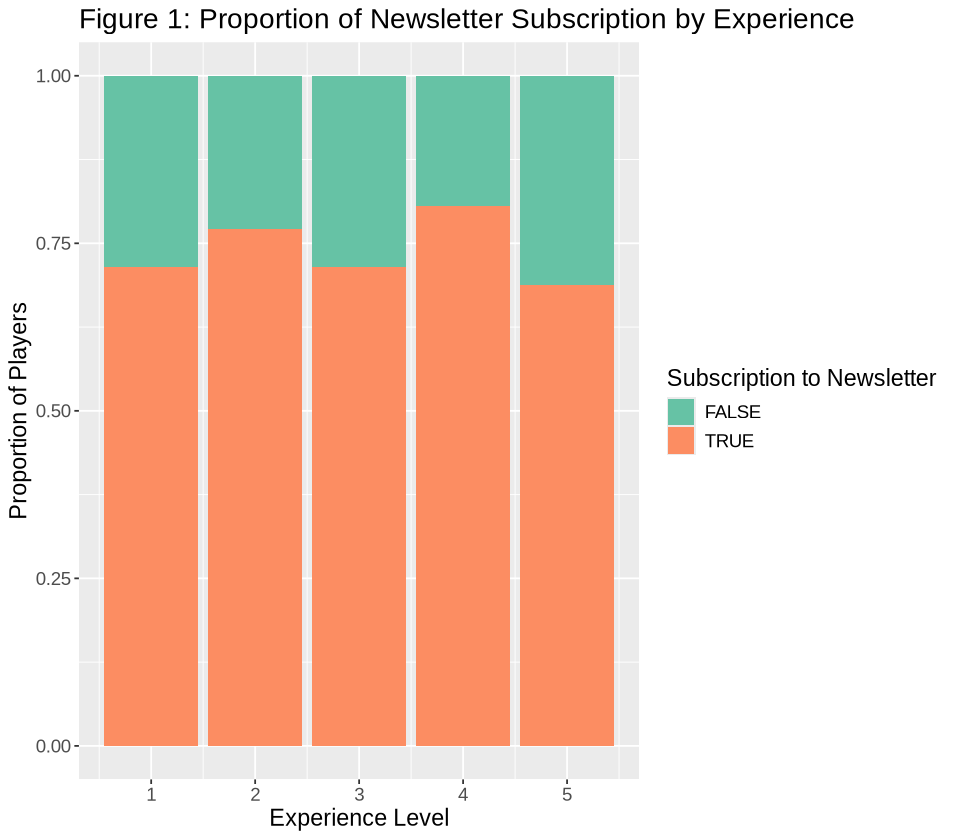

In [6]:
options(repr.plot.width = 8, repr.plot.height = 7)
ggplot(players_clean, aes(x=experience, fill = subscribe)) +
    geom_bar(position="fill") +
    theme(text = element_text(size = 14)) +
    labs(title = "Figure 1: Proportion of Newsletter Subscription by Experience", x = "Experience Level", y = "Proportion of Players", fill = "Subscription to Newsletter") +
    scale_fill_brewer(palette = "Set2")

From Figure 1, it is apparent that there is slight **variation** in the subscription levels for different classes. Class 4 has the highest subscription rate, while class 5 has the lowest. 

However, across the experience levels, roughly 75%  of all players are subscribed to a game-related newsletter. This means that a majority classifier that always guesses "TRUE" would have 75%~ accuracy. Ideally the classifier we build will have a higher accuracy to make further distinctions based on the 'experience' predictor.

### 2.4.2 Played Hours vs Subscription Status

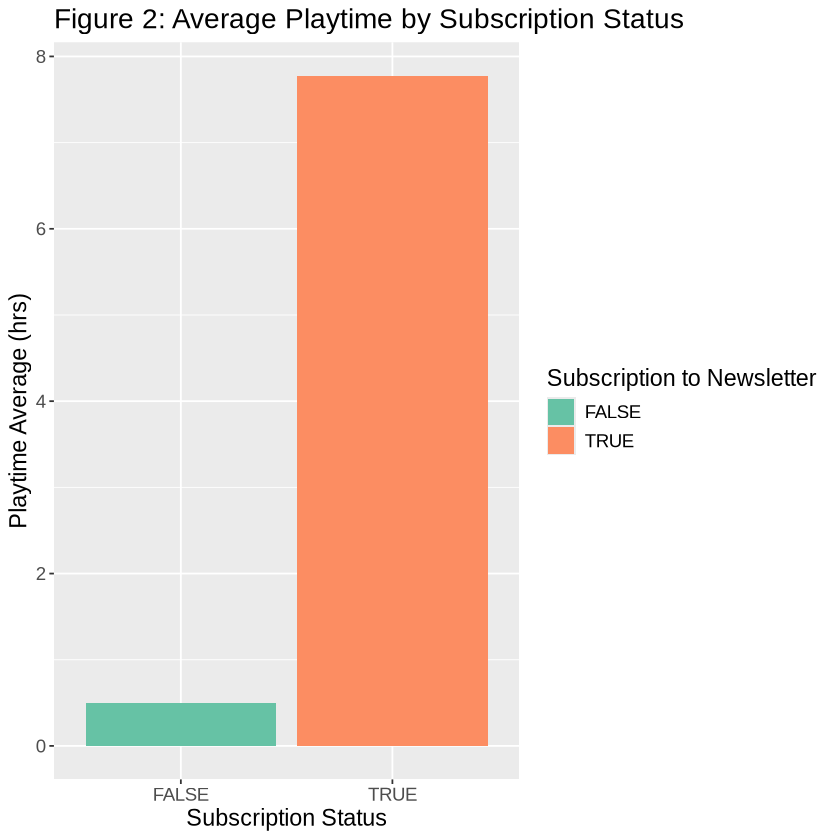

In [16]:
players_count <- players_clean |>
    group_by(subscribe) |>
    summarize(played_hours_average = mean(played_hours))

ggplot(players_count, aes(x=subscribe, y = played_hours_average, fill = subscribe)) +
    geom_bar(stat = "identity") +
    theme(text = element_text(size = 14)) +
    labs(title = "Figure 2: Average Playtime by Subscription Status", x = "Subscription Status", y = "Playtime Average (hrs)", fill = "Subscription to Newsletter") +
    scale_fill_brewer(palette = "Set2")

From figure 2, it can be observed that players subscribed to the newsletter **played more hours on average** (approximately 8x difference).



### 2.4.3 Played Hours vs Experience Level

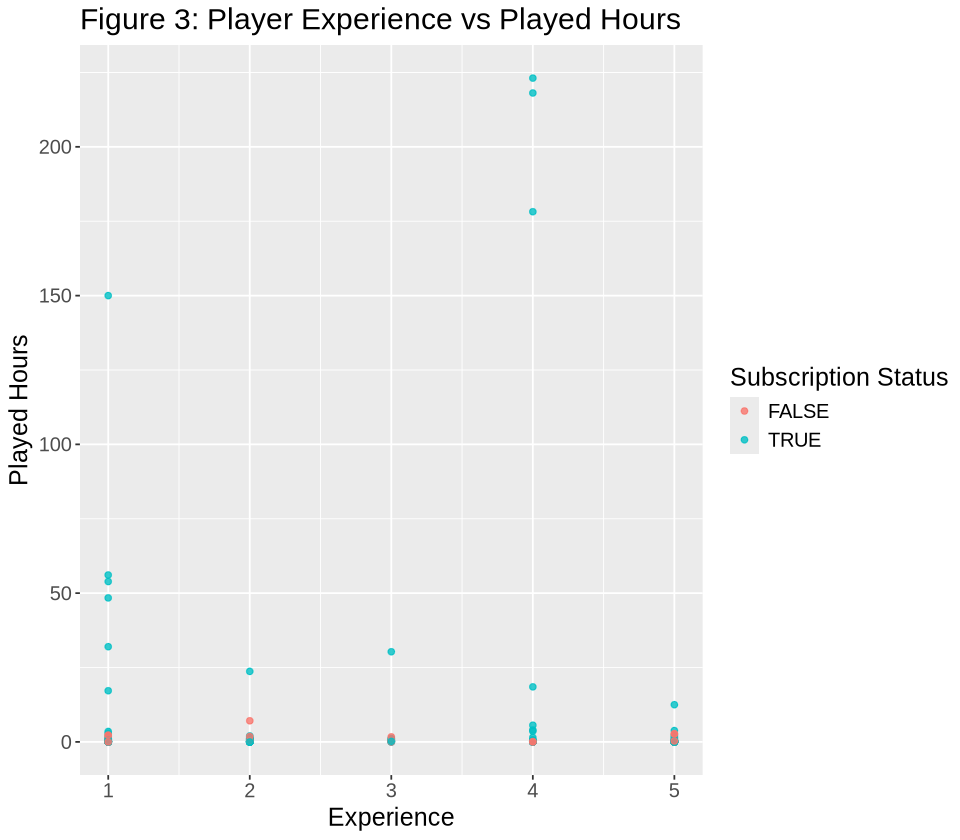

In [7]:
options(repr.plot.width = 8, repr.plot.height = 7)
ggplot(players_clean, aes(x = experience, y = played_hours, color = subscribe)) +
    geom_point(alpha = 0.8) +
    theme(text = element_text(size = 15)) +
    labs(title = "Figure 3: Player Experience vs Played Hours", x = "Experience", y = "Played Hours", color = "Subscription Status")

From figure 3, it can be observed that unsubscribed players of all classes played less hours on average than subscribed players in class 1 and 4. For classes 2, 3, and 5, subscribed players appeared to play the same number of hours on average compared to unsubscribed players in the same class. There are outliers of subscribed players in classes 2, 3, and 5, however, this will not be recognized as a trend, as there is not enough supporting data. 

## 2.5 Predictive Data Analysis

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.4898686,5,0.02697108,Preprocessor1_Model01
3,accuracy,binary,0.5429721,5,0.05778591,Preprocessor1_Model02
5,accuracy,binary,0.5636617,5,0.05001093,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
21,accuracy,binary,0.7348276,5,0.004190282,Preprocessor1_Model11
23,accuracy,binary,0.7348276,5,0.004190282,Preprocessor1_Model12
25,accuracy,binary,0.7348276,5,0.004190282,Preprocessor1_Model13


[1] 19

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7346939


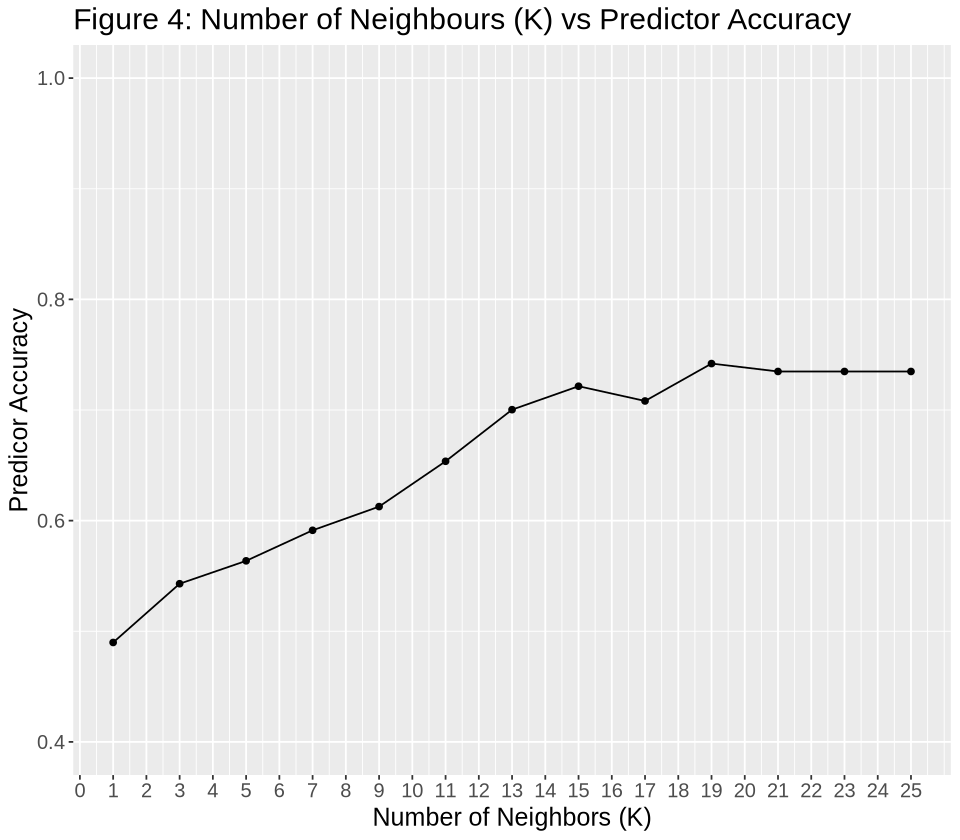

In [23]:
# Setting seed to ensure results do not vary if cell is continuously ran
set.seed(1111)

k_vals <- tibble(neighbors = seq(from = 1, to = 25, by = 2))

players_knn <- players_clean |>
  mutate(subscribe = as_factor(subscribe))  

# Making Initial Split
players_split <- initial_split(players_knn, prop = 0.75, strata = subscribe)
players_training <- training(players_split)
players_testing  <- testing(players_split)

# Training data using cross validation
players_recipe <- recipe(subscribe ~ experience + played_hours, data = players_training) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())


knn_spec <- nearest_neighbor(weight_func = "rectangular",neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

players_vfold <- vfold_cv(players_training, v = 5, strata = subscribe)


knn_results <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = players_vfold, grid = k_vals) |>
  collect_metrics()

# Finding best K
accuracies <- knn_results |>
  filter(.metric == "accuracy")
accuracies

# Visualization of best K
options(repr.plot.width = 8, repr.plot.height = 7)
best_k_plot <- accuracies |> 
ggplot(aes(x = neighbors, y = mean)) +
    geom_point() + 
    geom_line() + 
    scale_x_continuous(breaks = seq(0, 25, by = 1)) +  
    scale_y_continuous(limits = c(0.4, 1.0)) +
    labs(x = "Number of Neighbors (K)", y = "Predicor Accuracy", title = "Figure 4: Number of Neighbours (K) vs Predictor Accuracy") +
    theme(text = element_text(size=15))
best_k_plot

best_k <- accuracies |>
  arrange(desc(mean)) |>
  slice(1) |>
  pull(neighbors)
best_k

# Predicting on test data
players_recipe_final <- recipe(subscribe ~ experience + played_hours, data = players_training) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

knnspec_final <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(players_recipe_final) |>
  add_model(knnspec_final) |>
  fit(data = players_training)


players_test_predictions <- predict(knn_fit, players_testing) |>
  bind_cols(players_testing)

# Evaluating tuned model accuracy
players_test_accuracy <- players_test_predictions |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")

players_test_accuracy

# 3. Discussion

## 3.1 Summary of Findings

Our research question for this project was if experience level and play time could act as predictors for subscription status to a game-related newsletters in the players.csv dataset. From our exploratory and predictive analysis, it is observed that these variables are overall, weak predictors of player subscription status. 

To begin, when performing exploratory analysis, figure 1 showed that there was little distinction in subscription levels for different experience classes of players. There was no real trend, as all of the subscription percentiles within each class was ~75%. This was the first indication that experience level likely would have a negligable impact on if a player was subscribed or not. This would also contribute to a less accurate predictor because it has less of a pattern to go off of.

However, when looking at playtime, there was a clear distinction in subscription levels for players who played less versus more; figure 2 highlighted that players who had an average playtime of 0.5 hours during data collection were not subscribed to game-related newsletters. Contrastingly, it showed that players who had an average playtime of 7+ hours during the data collection were subscribed. This visualization had a clear pattern, which indicated that playtime would be a better predictor for the knn model.

Figure 3 showed that certain patterns were present for some experience classes, while no trends were observed for other classes. For example for classes 1 and 4, players that had a higher playtime appeared to have higher subscription levels. However, for classes 2, 3, and 5, despite some outlier data points, playtime did not appear to be correlated with subscription status. This confirmed that although playtime was a better predictor than experience level, there was no clear trend in the subscription status based on both predictors combined. This indicated that the predictor that we would create was likely to have low accuracy. 

Finally, our predictive analysis confirmed that our chosen variables failed to serve as predictors for subcription status. After finding the number of neighbors that resulted in the highest prediction accuracy, the accuracy was still only 73%. For a prediction model, this is extremely poor. The predictor will be incorrect about its predictions over a quater of the time! 

## 3.2 Alignment with expectations

Need to dicuss with group 

## 3.3 Impact of Findings 

The findings from this analysis have several important implications for the marketing companies/teams and corporations associated with the data set. First, the results show that experience level offers very limited value as a segmentation variable. Since subscription rates remained relatively consistent across all experience categories, marketers cannot rely on experience level to predict which players are likely to subscribe to newsletters. This means that campaigns designed to target players based on their experience level alone are unlikely to be effective or generate a meaningful return on investment.

While playtime showed a more noticeable relationship with subscription behaviour, particularly among players with very low or very high playtime, it still did not produce strong predictive accuracy when used in combination with experience level. This suggests that playtime may offer some contextual insight, such as differentiating highly engaged players from disengaged ones, but it is not a reliable standalone predictor for targeted marketing. It would be worth combining with another strongly predictive variable to get accurate predictions of the types of consumers that should be targeted for subscriptions. 

## 3.4 Implications for Future Research 

These findings point to several avenues for future research. One important potential extension of this research project at its root would be to collect additional data regarding behavioural variables that are more directly tied to marketing engagement, such as players’ interactions with promotional material and login frequency. If marketing implications is a direct focus for the research project leaders, even collecting attitudinal or motivational data in the pre-gameplay survey, may better capture the underlying reasons a player chooses to subscribe to game-related newsletters.

# 4. References

https://plaicraft.ai/faq/ethics